## Run model and collect predictions on BABILong

In [1]:
import os
os.chdir('..')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import datasets
from tqdm.auto import tqdm
import pandas as pd
import json

from pathlib import Path

from babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from babilong.babilong_utils import compare_answers

In [2]:
results_folder = './babilong_evals'
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'
dtype = torch.bfloat16
device = 'cuda:0'

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True,
                                             device_map=device, torch_dtype=dtype,
                                             attn_implementation='flash_attention_2')
model = model.eval()

/home/jovyan/envs/py3.11_pt2_cu11.8/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/jovyan/envs/py3.11_pt2_cu11.8/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
generate_kwargs = {
    'num_beams': 1,
    'do_sample': False,
    'temperature': None,
    'top_p': None,
    'top_k': None,
}
if tokenizer.pad_token_id is None:
    generate_kwargs['pad_token_id'] = tokenizer.eos_token_id

default prompt template

In [5]:
print(DEFAULT_TEMPLATE)

{instruction}

{examples}

{post_prompt}

<context>
{context}
</context>

Question: {question}


## Run model without any prompt
Only context and question are shown to model

In [6]:
# following recommedation from https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2
# we use tokenizer.apply_chat_template
# messages = [{"role": "user", "content": DEFAULT_TEMPLATE}]

In [ ]:
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5'] #,['qa1', 'qa2', 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
split_names = ['1k', '2k', '4k', '8k', '16k', '32k'] # ['1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k']

for task in tqdm(tasks, desc='tasks'):
    prompt_cfg = {
        'instruction': '', # DEFAULT_PROMPTS[task]['instruction'],
        'examples': '', # DEFAULT_PROMPTS[task]['examples'],
        'post_prompt': '', # DEFAULT_PROMPTS[task]['post_prompt'],
        'template': DEFAULT_TEMPLATE,
    }
    prompt_name = [f'{k}_no' if len(prompt_cfg[k]) == 0 else f'{k}_yes' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)

    for split_name in tqdm(split_names, desc='lengths'):
        data = datasets.load_dataset("booydar/babilong-1k-samples", split_name)
        task_data = data[task]

        # prepare files with predictions, prompt, and generation cofigurations
        outfile = Path(f'{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'./{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': []})

        for sample in task_data:
            target = sample['target']
            context = sample['input']
            question = sample['question']

            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                             prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                             template=DEFAULT_TEMPLATE)
            
            input_text = [{"role": "user", "content": input_text}]

            model_inputs = tokenizer.apply_chat_template(input_text, return_tensors="pt").to(model.device)
            sample_length = model_inputs.shape[1]
            with torch.no_grad():
                output = model.generate(model_inputs, max_new_tokens=15, **generate_kwargs)
            output = output[0][sample_length:]
            output = tokenizer.decode(output, skip_special_tokens=True).strip()

            df.loc[len(df)] = [target, output]
            df.to_csv(outfile)

## Run model with instruction and in-context examples

In [ ]:
for task in tqdm(tasks, desc='tasks'):
    prompt_cfg = {
        'instruction': DEFAULT_PROMPTS[task]['instruction'],
        'examples': DEFAULT_PROMPTS[task]['examples'],
        'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'],
        'template': DEFAULT_TEMPLATE,
    }
    prompt_name = [f'{k}_no' if len(prompt_cfg[k]) == 0 else f'{k}_yes' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)

    for split_name in tqdm(split_names, desc='lengths'):
        data = datasets.load_dataset("booydar/babilong-1k-samples", split_name)
        task_data = data[task]

        # prepare files with predictions, prompt, and generation cofigurations
        outfile = Path(f'{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'./{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': []})

        for sample in task_data:
            target = sample['target']
            context = sample['input']
            question = sample['question']

            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                             prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                             template=DEFAULT_TEMPLATE)
            
            input_text = [{"role": "user", "content": input_text}]

            model_inputs = tokenizer.apply_chat_template(input_text, return_tensors="pt").to(model.device)
            sample_length = model_inputs.shape[1]
            with torch.no_grad():
                output = model.generate(model_inputs, max_new_tokens=15, **generate_kwargs)
            output = output[0][sample_length:]
            output = tokenizer.decode(output, skip_special_tokens=True).strip()

            df.loc[len(df)] = [target, output]
            df.to_csv(outfile)

## Evaluate results

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

# import os
# os.chdir('..')

## Eval results with instruction and in-context examples

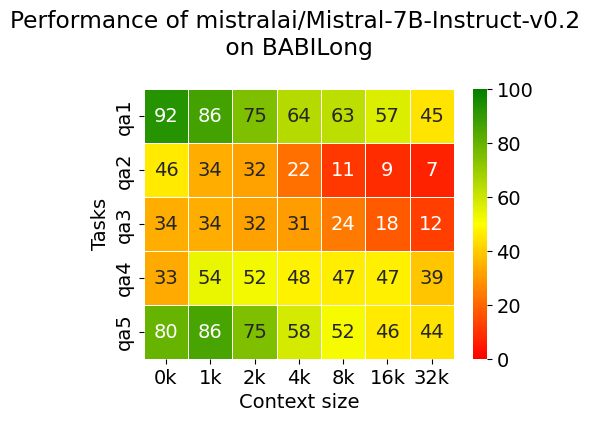

In [6]:
results_folder = './babilong_evals'
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes'

tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k']
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Performance of {model_name} \n on BABILong \n')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

## Eval results without any prompt

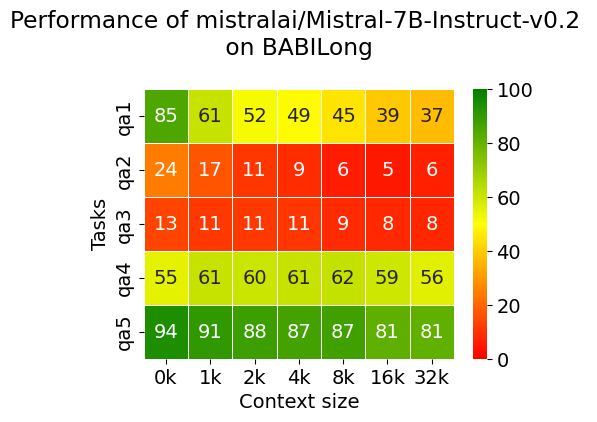

In [7]:
results_folder = './babilong_evals'
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'
prompt_name = 'instruction_no_examples_no_post_prompt_no'

tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k']
accuracy = np.zeros((len(tasks), len(lengths)))

for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Performance of {model_name} \n on BABILong \n')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()